In [1]:
import os
import numpy as np
import nibabel as nib
from scipy.spatial import ConvexHull, Delaunay
from scipy.ndimage import binary_dilation
from sklearn.decomposition import PCA
from medpy.filter.smoothing import anisotropic_diffusion
from medpy.filter.binary import largest_connected_component
from medpy.io import load, save

import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, base_path, num_subjects=104):
        self.base_path = base_path
        self.num_subjects = num_subjects

    def __len__(self):
        return self.num_subjects

    def __getitem__(self, idx):
        file_path = os.path.join(self.base_path, f'{idx+1:03d}/{idx+1:03d}_ChP_mask_T1xFLAIR_manual_seg.nii')
        img = nib.load(file_path)
        data = img.get_fdata()
        return torch.tensor(data, dtype=torch.float32)
    
class T1xFLAIRDataset(Dataset):
    def __init__(self, base_path, num_subjects=104):
        self.base_path = base_path
        self.num_subjects = num_subjects

    def __len__(self):
        return self.num_subjects

    def __getitem__(self, idx):
        file_path = os.path.join(self.base_path, f'{idx+1:03d}/{idx+1:03d}_T1xFLAIR.nii')
        img = nib.load(file_path)
        data = img.get_fdata()
        return torch.tensor(data, dtype=torch.float32)

def create_probability_map(segmentations, num_subjects):
    sum_seg = torch.sum(segmentations, dim=0)
    probability_map = sum_seg / num_subjects
    return probability_map


def create_scan_path(probability_map, threshold=0.07, min_distance=10):
    '''
    Generates a scan path by selecting the two highest probability points from each z-slice of a given probability map,
    excluding slices where the maximum probability is below a specified threshold and ensuring the points are at least
    a specified distance apart.
    Args:
        probability_map (torch.Tensor): A 3D tensor representing the probability map.
        threshold (float, optional): The minimum probability value to consider a slice significant. Default is 0.1.
        min_distance (int, optional): The minimum distance between the two highest probability points. Default is 10 pixels.
    Returns:
        list of tuple: A list of tuples representing the coordinates of the selected points in the scan path.
    '''
    scan_path = []
    prob_map_copy = probability_map.clone()
    
    # Iterate over each z-slice
    for z in range(prob_map_copy.shape[2]):
        slice_2d = prob_map_copy[:, :, z]
        
        # Check if the maximum probability in the slice is above the threshold
        if torch.max(slice_2d) < threshold:
            continue
        
        # Get the indices of the highest value in the 2D slice
        max_idx1 = torch.argmax(slice_2d)
        coord1 = np.unravel_index(max_idx1.item(), slice_2d.shape) # bring the index to 2Din the original shape of slice_2d
        
        # Set to 0 a region around the first maximum to ensure the second maximum is at least `min_distance` away to assure < threshold
        x1, y1 = coord1
        x_min = max(0, x1 - min_distance)
        x_max = min(slice_2d.shape[0], x1 + min_distance + 1)
        y_min = max(0, y1 - min_distance)
        y_max = min(slice_2d.shape[1], y1 + min_distance + 1)
        slice_2d[x_min:x_max, y_min:y_max] = 0 # set the region around the first maximum to 0 (including the first maximum)
        
        # Get the indices of the second highest value in the 2D slice
        max_idx2 = torch.argmax(slice_2d)
        coord2 = np.unravel_index(max_idx2.item(), slice_2d.shape)
        
        # Append the coordinates to the scan path
        scan_path.append((coord1[0], coord1[1], z))
        scan_path.append((coord2[0], coord2[1], z))
    
    return scan_path




def visualize_probability_map(probability_map, slice_index=None):
    if slice_index is None:
        # Display the middle slice if no index is provided
        slice_index = probability_map.shape[2] // 2
    
    plt.figure(figsize=(10, 8))
    plt.imshow(probability_map[:, :, slice_index], cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Probability Map - Slice {slice_index}')
    plt.show()



In [3]:
base_path = '/mnt/turing/LIA/pazienti/'
base_path = '/mnt/LIA/pazienti/'
dataset = SegmentationDataset(base_path)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

dataset_t1xflair = T1xFLAIRDataset(base_path)
dataloader_t1xflair = DataLoader(dataset_t1xflair, batch_size=1, shuffle=False)

num_subjects = len(dataset)
segmentations = []
t1xflairs = []
for batch in dataloader:
    segmentations.append(batch.squeeze(0))
for batch in dataloader_t1xflair:
    t1xflairs.append(batch.squeeze(0))
segmentations = torch.stack(segmentations)
t1xflairs = torch.stack(t1xflairs)
probability_map = create_probability_map(segmentations, num_subjects)


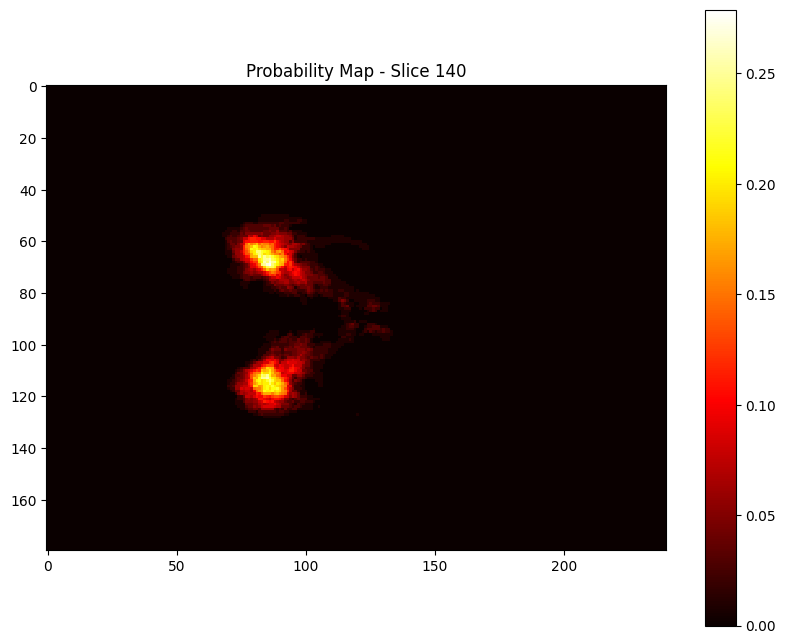

In [4]:

visualize_probability_map(probability_map.numpy(), 140)

In [5]:
import ants
from nilearn import plotting, datasets
import nibabel as nib
from nilearn.datasets import load_mni152_template


In [ ]:

# Load the MNI152 template at the specified resolution (2mm)
mni_template_path = 'mni_icbm152_t1_tal_nlin_asym_09c.nii.gz'
save_prob_path = "/var/datasets/LIA/probability_map.nii.gz"
def visualize_probability_map_3d(probability_map):
    """
    Visualize a probability map by coregistering it to the MNI152 template
    and displaying the result.
    
    :param probability_map: Torch tensor or NumPy array (3D), the probability map to visualize.
    """
    # Ensure the probability map is a NumPy array
    if not isinstance(probability_map, np.ndarray):
        probability_map = probability_map.numpy()

    # Convert the probability map to a NIfTI image
    prob_map_img = nib.Nifti1Image(probability_map, np.eye(4))
    
    # Save the probability map to a temporary file
    nib.save(prob_map_img, save_prob_path)
    
    # Load the MNI template and the probability map into ANTs
    mni_template_ants = ants.image_read(mni_template_path)
    prob_map_img_ants = ants.image_read(save_prob_path)
    
    # Perform affine registration
    registration = ants.registration(
        fixed=mni_template_ants,
        moving=prob_map_img_ants,
        type_of_transform='Affine'
    )

    # Apply the forward transformation to the probability map
    prob_map_mni = ants.apply_transforms(
        fixed=mni_template_ants,
        moving=prob_map_img_ants,
        transformlist=registration['fwdtransforms']
    )

    # Save the transformed probability map to a file
    ants.image_write(prob_map_mni, save_prob_path)
    
    # Load the transformed probability map into nibabel
    prob_map_mni_img = nib.load(save_prob_path)
    
    # Visualize the result using nilearn
    plotting.plot_glass_brain(
        prob_map_mni_img,
        display_mode='ortho',
        colorbar=True,
        title='Probability Map in MNI Space'
    )
    plotting.show()


# Example usage
visualize_probability_map_3d(probability_map)

hull: <scipy.spatial._qhull.ConvexHull object at 0x7cebad5f9cd0>
hull_p: [[0.93700547 0.12990805]
 [0.87615686 0.99595749]
 [0.02866482 0.90464729]
 [0.01011861 0.6883804 ]
 [0.07082369 0.17625588]
 [0.09857492 0.11127031]
 [0.21870728 0.05985602]
 [0.70930879 0.00507554]
 [0.73104494 0.01660658]]
type hull_p: <class 'numpy.ndarray'>


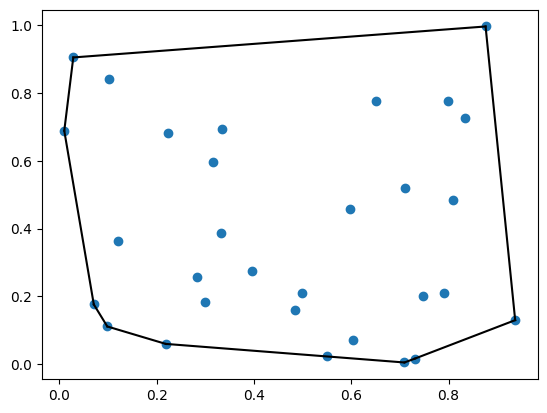

In [6]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
rng = np.random.default_rng()
points = rng.random((30, 2))   # 30 random points in 2-D
hull = ConvexHull(points)
hull_p = points[hull.vertices]

print("hull:", hull)
print("hull_p:", hull_p)
print("type hull_p:", type(hull_p))

import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [4]:
# ! https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html

def create_convex_hull_with_margin(segmentations, margin=5):
    """
    Create a convex hull with a margin around the given segmentations.
    (The smallest convex set that contains all the points in a given set.)
    Parameters:
    segmentations (list of torch.Tensor): A list of PyTorch tensors representing the segmentations.
    margin (int, optional): The margin to apply around the convex hull. Default is 5.
    Returns:
    tuple: A tuple containing:
        - hull_with_margin_in_orig_vol (numpy.ndarray): A 3D numpy array with the convex hull of the segmentations with the specified margin.
        - hull (scipy.spatial.ConvexHull): The convex hull object.
    """
    '''

    '''
    # todo: think about whether margin is useful or not -> probably depends on what we want to do with the hull
    # -> either creating patches or using it for the scan path?
    
    # Output: 3D numpy array with the convex hull of the segmentations with a margin
    
    # Convert PyTorch tensors to numpy arrays
    segmentations_np = [seg.numpy() for seg in segmentations]
    
    # delete index 16 and 39
    #del segmentations_np[38] # todo delete this once scp corrected data to pazienti
    #del segmentations_np[15]
    
    combined_seg = np.sum(segmentations_np, axis=0) > 0
    print("combined_seg shape:", combined_seg.shape)

    points = np.argwhere(combined_seg) # get the coordinates of the points in the hull
    print("points shape:", points.shape)
    hull = ConvexHull(points)
    hull_points = points[hull.vertices] # 3d array here (vertices of the convex hull.)
    
    # Create an empty volume and set the points in the convex hull to 1
    hull_volume = np.zeros_like(combined_seg)
    for point in hull_points:
        hull_volume[tuple(point)] = 1.
    
    # Apply dilation to add margin
    # ! lets not keep mamrgin, i think it's is irrelevant..
    # multiply by 1.0 to convert the boolean array to float
    hull_with_margin_in_orig_vol = binary_dilation(hull_volume, iterations=margin) * 1.0
    return hull_with_margin_in_orig_vol, hull


def create_convex_hull(segmentations):
    """
    Create a convex hull with a margin around the given segmentations.
    (The smallest convex set that contains all the points in a given set.)
    Parameters:
    segmentations (list of torch.Tensor): A list of PyTorch tensors representing the segmentations.
    Returns:
    tuple: A tuple containing:
        - hull_volume (numpy.ndarray): A 3D numpy array with the convex hull of the segmentations.
        - hull (scipy.spatial.ConvexHull): The convex hull object.
    """
    '''

    '''
    # todo: think about whether margin is useful or not -> probably depends on what we want to do with the hull
    # -> either creating patches or using it for the scan path?
    
    
    # Convert PyTorch tensors to numpy arrays
    segmentations_np = [seg.numpy() for seg in segmentations]
    
    combined_seg = np.sum(segmentations_np, axis=0) > 0
    print("combined_seg shape:", combined_seg.shape)

    points = np.argwhere(combined_seg) # get the coordinates of the points in the hull
    print("points shape:", points.shape)
    hull = ConvexHull(points)
    hull_points = points[hull.vertices] # 3d array here (vertices of the convex hull.)
    
    # Create an empty volume and set the points in the convex hull to 1
    hull_volume = np.zeros_like(combined_seg)
    for point in hull_points:
        hull_volume[tuple(point)] = 1.
    
    return hull_volume, hull, points


    
def adapt_scan_path_for_subject(general_scan_path_path, subject_img_path, output_path):
    '''
    Adapts the general scan path to a specific subject by using the header of the subject's MRI scan.
    Args:
        general_scan_path_path (str): Path to the general scan path NIfTI image.
        subject_img_path (str): Path to the subject's MRI scan NIfTI image.
        output_path (str): Path to save the adapted scan path NIfTI image.
    '''
    # Load the general scan path and the subject's MRI scan
    general_scan_path_img = nib.load(general_scan_path_path)
    subject_img = nib.load(subject_img_path)
    
    # Get the header and affine from the subject's MRI scan
    header = subject_img.header
    affine = subject_img.affine
    
    # Create a new NIfTI image with the general scan path data and the subject's header
    adapted_scan_path_img = nib.Nifti1Image(general_scan_path_img.get_fdata(), affine, header)
    
    # Save the adapted scan path image
    nib.save(adapted_scan_path_img, output_path)
    
    
def project_convex_hull_to_yz(convex_hull):
    '''
    Projects the convex hull onto the Y-Z plane.
    Args:
        convex_hull (np.ndarray): A 3D numpy array representing the convex hull.
    Returns:
        np.ndarray: A 2D numpy array representing the projection onto the Y-Z plane.
    '''
    # Sum along the X-axis to project onto the Y-Z plane
    yz_projection = np.max(convex_hull, axis=0)
    return yz_projection

def compute_convex_hull_2d(yz_projection):
    '''
    Computes the convex hull of the projected Y-Z plane.
    Args:
        yz_projection (np.ndarray): A 2D numpy array representing the projection onto the Y-Z plane.
    Returns:
        np.ndarray: A 2D numpy array representing the convex hull of the projection.
    '''
    # Get the coordinates of the non-zero points
    points = np.argwhere(yz_projection)
    
    # Compute the convex hull
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    
    # Create an empty volume
    hull_volume = np.zeros_like(yz_projection, dtype=float)
    for point in hull_points:
        hull_volume[tuple(point)] = 1.0
    
    return hull_volume


from skimage.morphology import skeletonize

def compute_skeleton(yz_projection):
    '''
    Computes the skeleton of the projected convex hull.
    Args:
        yz_projection (np.ndarray): A 2D numpy array representing the projection onto the Y-Z plane.
    Returns:
        np.ndarray: A 2D numpy array representing the skeleton of the projection.
    '''
    binary_projection = yz_projection > 0 #(to assure that input so skelenozie is binary)
    
    # Compute the skeleton
    skeleton = skeletonize(binary_projection)
    return skeleton

def create_volume_from_skeleton(skeleton, original_shape):
    '''
    Creates a 3D volume by repeating the 2D skeleton along the X-axis.
    Args:
        skeleton (np.ndarray): A 2D numpy array representing the skeleton of the projection.
        original_shape (tuple): The shape of the original 3D volume.
    Returns:
        np.ndarray: A 3D numpy array with the skeleton repeated along the X-axis.
    '''
    # Create an empty volume with the same shape as the original volume
    volume = np.zeros(original_shape, dtype=float)
    
    # Repeat the 2D skeleton along the X-axis
    for x in range(original_shape[0]):
        volume[x, :, :] = skeleton
    
    return volume


from scipy.ndimage import binary_dilation

def create_volume_within_convex_hull(segmentations, margin=5):
    '''
    Creates a 3D volume with ones inside the convex hull and zeros outside.
    Args:
        convex_hull_points (np.ndarray): A 3D numpy array representing the convex hull.
                                        Coordinates of points to triangulate
        
    '''
    
    convex_hull_vol, hull, points = 
    (segmentations)
    
    print("convex_hull_vol:", convex_hull_vol.shape)
    
    # Create an empty volume of the same shape as the convex hull
    volume = np.zeros_like(convex_hull_vol, dtype=float)
    
    print("hull_points.vertices:", hull.vertices.shape)
    # Create delunay triangulation: set of simplexes (triangles) where each point of hull.vertices is a vertex on a few of the simplexes
    delun = Delaunay(points[hull.vertices])
    
    # Create a mask with ones inside the convex hull and zeros outside
    for x in range(volume.shape[0]):
        for y in range(volume.shape[1]):
            for z in range(volume.shape[2]):
                # Find the simplices containing the given points. 
                # returned integers in the array are the indices of the simplex the corresponding point is in. If -1 is returned, the point is in no simplex
                if delun.find_simplex([x, y, z]) >= 0:
                    volume[x, y, z] = 1.0
    
    # Apply dilation to add margin
    volume_with_margin = binary_dilation(volume, iterations=margin) * 1.0
    
    return volume_with_margin
        




In [192]:
def extract_patches(volume, scan_path, patch_size=(32, 32, 32)):
    patches = []
    half_patch_size = tuple(size // 2 for size in patch_size)
    
    for coord in scan_path:
        start = [max(0, c - h) for c, h in zip(coord, half_patch_size)]
        end = [min(s, c + h) for c, h, s in zip(coord, half_patch_size, volume.shape)]
        
        patch = volume[start[0]:end[0], start[1]:end[1], start[2]:end[2]]
        patches.append(patch)
    
    return torch.stack(patches)

In [8]:
# Create scan path
scan_path = create_scan_path(probability_map)
scan_path

[(np.int64(115), np.int64(81), 123),
 (np.int64(57), np.int64(84), 123),
 (np.int64(122), np.int64(94), 124),
 (np.int64(58), np.int64(84), 124),
 (np.int64(121), np.int64(92), 125),
 (np.int64(56), np.int64(91), 125),
 (np.int64(121), np.int64(90), 126),
 (np.int64(57), np.int64(90), 126),
 (np.int64(121), np.int64(89), 127),
 (np.int64(55), np.int64(90), 127),
 (np.int64(120), np.int64(87), 128),
 (np.int64(58), np.int64(87), 128),
 (np.int64(59), np.int64(86), 129),
 (np.int64(119), np.int64(84), 129),
 (np.int64(60), np.int64(85), 130),
 (np.int64(119), np.int64(85), 130),
 (np.int64(60), np.int64(84), 131),
 (np.int64(118), np.int64(84), 131),
 (np.int64(61), np.int64(87), 132),
 (np.int64(117), np.int64(84), 132),
 (np.int64(62), np.int64(84), 133),
 (np.int64(117), np.int64(85), 133),
 (np.int64(62), np.int64(87), 134),
 (np.int64(117), np.int64(86), 134),
 (np.int64(62), np.int64(86), 135),
 (np.int64(117), np.int64(86), 135),
 (np.int64(63), np.int64(84), 136),
 (np.int64(116)

In [194]:
adapt_scan_path_for_subject(general_scan_path_path='/var/datasets/LIA/scan_path_10.nii.gz', subject_img_path='/mnt/turing/LIA/pazienti/051/051_T1xFLAIR.nii', output_path='/mnt/turing/LIA/pazienti/051/051_scan_path.nii.gz')

FileNotFoundError: No such file or no access: '/mnt/turing/LIA/pazienti/051/051_T1xFLAIR.nii'

In [184]:
# Convert list with tuples to segmentation mask: volume of size 180x240x240 and save it to path as .nii.gz
scan_path_vol = np.zeros(probability_map.shape)
for point in scan_path:
    scan_path_vol[point] = 1.
    
scan_path_volume = nib.Nifti1Image(scan_path_vol, np.eye(4))
#nib.save(scan_path_volume, '/var/datasets/LIA/scan_path_10.nii.gz')




In [5]:
convex_hull_vol, hull = create_convex_hull_with_margin(segmentations)



combined_seg shape: (180, 240, 240)
points shape: (79128, 3)


In [13]:
hull.vertices

array([    0,     2,     5,     6,     8,     9,    13,    42,    92,
         102,   232,   263,   264,   287,   305,   477,   525,   540,
         739,   778,   836,   990,   995,  1158,  1597,  1686,  2378,
        2398,  2528,  2581,  2911,  3277,  4241,  4341,  4445,  4607,
        5311,  5333,  5483,  5687,  6775,  7624,  9092,  9526, 10243,
       11154, 11155, 12338, 12346, 12350, 12470, 13254, 14450, 14640,
       14649, 16934, 18706, 19270, 20656, 22949, 25548, 25837, 29318,
       29816, 31231, 32646, 34283, 35228, 35751, 37663, 39490, 39539,
       39542, 39794, 39845, 39848, 40477, 40488, 40490, 41140, 41903,
       43648, 43678, 44684, 44697, 45630, 45737, 45740, 46727, 52994,
       53034, 54167, 54207, 55157, 55667, 56336, 56685, 56779, 56790,
       58387, 58605, 59036, 59927, 60499, 61354, 63732, 64801, 64821,
       67206, 67593, 67685, 68452, 69703, 69710, 70984, 71024, 71636,
       72320, 72635, 72636, 72720, 73091, 73133, 73477, 73534, 73558,
       73778, 74168,

In [187]:

convex_hull_volume = nib.Nifti1Image(convex_hull_vol, np.eye(4))
#nib.save(convex_hull_volume, '/var/datasets/LIA/convex_hull_volume.nii.gz')

In [167]:
adapt_scan_path_for_subject(general_scan_path_path='/var/datasets/LIA/convex_hull_volume.nii.gz', subject_img_path='/mnt/turing/LIA/pazienti/051/051_T1xFLAIR.nii', output_path='/mnt/turing/LIA/pazienti/051/051_convex_hull_volume.nii.gz')

FileNotFoundError: No such file or no access: '/var/datasets/LIA/convex_hull_volume.nii.gz'

# Idea: Project convex hull onto yz Plane to then fit curve of minial distance into convex hull of projection

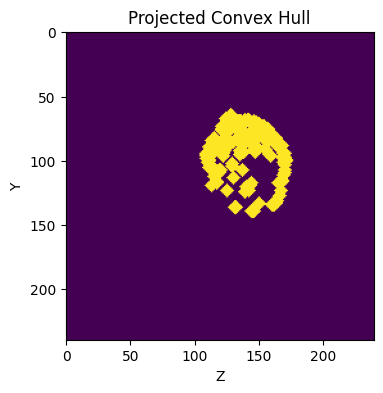

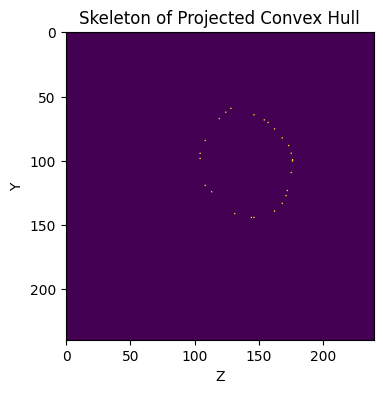

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [18]:
# Project the convex hull onto the Y-Z plane
yz_projection = project_convex_hull_to_yz(convex_hull_vol)
# Compute the convex hull of the projected Y-Z plane
yz_convex_hull = compute_convex_hull_2d(yz_projection)
# Compute the skeleton of the projected convex hull
skeleton = compute_skeleton(yz_convex_hull)
# Create a 3D volume from the skeleton
skeleton_volume = create_volume_from_skeleton(skeleton, convex_hull_vol.shape)


plt.figure(figsize=(4, 4))
plt.imshow(yz_projection)
plt.title('Projected Convex Hull')
plt.xlabel('Z')
plt.ylabel('Y')
plt.show()

plt.figure(figsize=(4, 4))
plt.imshow(skeleton)
plt.title('Skeleton of Projected Convex Hull')
plt.xlabel('Z')
plt.ylabel('Y')
plt.show()

print(skeleton_volume)

In [8]:
convex_hull_entire_volume = create_volume_within_convex_hull(segmentations)

combined_seg shape: (180, 240, 240)
points shape: (79128, 3)
convex_hull_vol: (180, 240, 240)
hull_points.vertices: (163,)


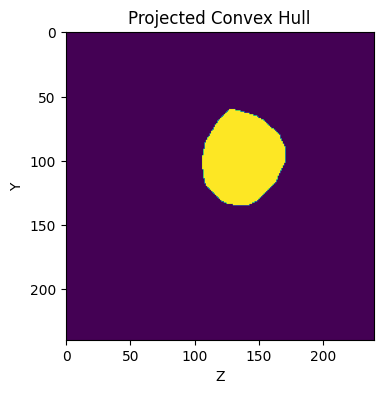

In [9]:
plt.figure(figsize=(4, 4))
plt.imshow(convex_hull_entire_volume[70,:,:])
plt.title('Projected Convex Hull')
plt.xlabel('Z')
plt.ylabel('Y')
plt.show()

In [10]:
convex_hull_entire_volume_final = nib.Nifti1Image(convex_hull_entire_volume, np.eye(4))
#nib.save(convex_hull_entire_volume_final, '/var/datasets/LIA/convex_hull_entire_volume_final.nii.gz')

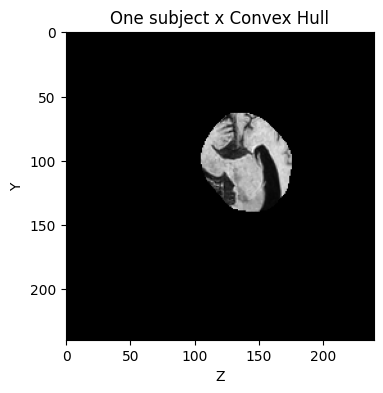

In [15]:
idx = 10
subj_x_convex_hull = np.multiply(t1xflairs[idx].numpy(), convex_hull_entire_volume)
plt.figure(figsize=(4, 4))
plt.imshow(subj_x_convex_hull[100,:,:], cmap='grey')
plt.title('One subject x Convex Hull')
plt.xlabel('Z')
plt.ylabel('Y')
plt.show()

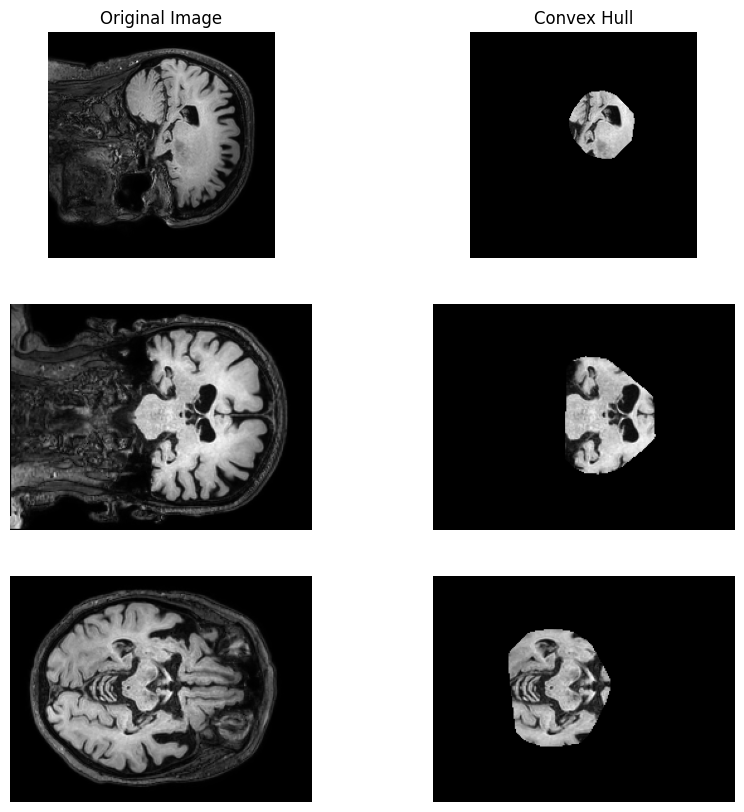

In [16]:
# plot original image and convex hull multiplied next to each other
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs[0, 0].imshow(t1xflairs[idx][110,:,:], cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')
axs[0, 1].imshow(subj_x_convex_hull[110,:,:], cmap='gray')
axs[0, 1].set_title('Convex Hull')
axs[0, 1].axis('off')
axs[1, 0].imshow(t1xflairs[idx][:,100,:], cmap='gray')
axs[1, 0].axis('off')
axs[1, 1].imshow(subj_x_convex_hull[:,100,:], cmap='gray')
axs[1, 1].axis('off')
axs[2, 0].imshow(t1xflairs[idx][:,:,130], cmap='gray')
axs[2, 0].axis('off')
axs[2, 1].imshow(subj_x_convex_hull[:,:,130], cmap='gray')
axs[2, 1].axis('off')
plt.show()





